# Pre processing for skin lesion dataset

In [1]:
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomBrightness


In [31]:
# Visualização
def show_images(img_list, titles=None):
    """
    Função auxiliar para exibir uma lista de imagens.

    Args:
        img_list (list): Lista de imagens a serem exibidas.
        titles (list, optional): Lista de títulos para cada imagem. Defaults to None.
    """
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(img_list):
        plt.subplot(1, len(img_list), i+1)
        plt.imshow(img, cmap='viridis')
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Etapa 1.1: Redimensionamento
class Resize(BaseEstimator, TransformerMixin):
    """
    Redimensiona as imagens para um tamanho fixo.
    
    Args:
        size (tuple, optional): O tamanho para o qual as imagens serão redimensionadas.
            Defaults to (128, 128).
    """
    def __init__(self, size=(128, 128)):
        self.size = size
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([cv2.resize(img, self.size) for img in X])

# Etapa 1.2: Normalização
class Normalize(BaseEstimator, TransformerMixin):
    def __init__(self, scaling='minmax'):
        """
        Normaliza as imagens.

        Args:
            scaling (str, optional): O tipo de escalonamento a ser aplicado.
                'minmax': Escala os valores para o intervalo [0, 1].
                'meanstd': Centraliza os dados com média zero e desvio padrão unitário (por canal).
                Defaults to 'minmax'.
        """
        self.scaling = scaling
        self.mean = None
        self.std = None

    def fit(self, X):
        if self.scaling == 'meanstd':
            # Calcula a média e o desvio padrão por canal para o conjunto de treinamento
            X = np.array(X)
            if X.ndim == 4: 
                self.mean = np.mean(X, axis=(0, 1, 2), keepdims=True)
                self.std = np.std(X, axis=(0, 1, 2), keepdims=True)
            elif X.ndim == 3: 
                self.mean = np.mean(X, axis=(0, 1), keepdims=True)
                self.std = np.std(X, axis=(0, 1), keepdims=True)
            else:
                raise ValueError("Formato de entrada não suportado para 'meanstd' scaling.")
        return self

    def transform(self, X):
        X = np.array(X, dtype=np.float32)
        if self.scaling == 'minmax':
            min_val = np.min(X)
            max_val = np.max(X)
            # Evita divisão por zero se min_val == max_val
            return (X - min_val) / (max_val - min_val + 1e-8)
        elif self.scaling == 'meanstd':
            if self.mean is None or self.std is None:
                raise ValueError("O método 'fit' deve ser chamado antes de 'transform' com scaling='meanstd'.")
            return (X - self.mean) / (self.std + 1e-8)
        else:
            raise ValueError(f"Tipo de escalonamento '{self.scaling}' não suportado.")
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
# Etapa 2: Filtro Gaussiano (remoção de ruído)
class GaussianBlur(BaseEstimator, TransformerMixin):
    """
    Aplica um filtro gaussiano para remoção de ruído.
    
    Args:
        ksize (tuple, optional): Tamanho do kernel gaussiano. Defaults to (5, 5).
        sigma (float, optional): Desvio padrão da distribuição gaussiana. Defaults to 0.
    """
    def __init__(self, ksize=(5, 5), sigma=0):
        self.ksize = ksize
        self.sigma = sigma

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([cv2.GaussianBlur(img, self.ksize, self.sigma) for img in X])

# Etapa 3  (versão 1): CLAHE (Equalização de histograma adaptativa)
class CLAHE(BaseEstimator, TransformerMixin):
    """
    Aplica CLAHE (Contrast Limited Adaptive Histogram Equalization) em imagens.

    Args:
        clip_limit (float, optional): Limite de recorte para CLAHE. Defaults to 2.0.
        tile_grid_size (tuple, optional): Tamanho da grade para CLAHE. Defaults to (8, 8).
    """
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([self.clahe.apply(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) for img in X])

# Etapa 3 (versão 2): CLAHE aplicado em cada canal de cor (BGR)
class CLAHE_Color(BaseEstimator, TransformerMixin):
    """
    Aplica CLAHE em cada canal de cor (BGR) de uma imagem.

    Args:
        clip_limit (float, optional): Limite de recorte para CLAHE. Defaults to 2.0.
        tile_grid_size (tuple, optional): Tamanho da grade para CLAHE. Defaults to (8, 8).
    """
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        processed_images = []
        for img in X:
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            cl = clahe.apply(l)
            merged_lab = cv2.merge((cl, a, b))
            processed_img = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)
            processed_images.append(processed_img)
        return np.array(processed_images)

# Etapa 4: Segmentação simples usando Otsu
class OtsuThreshold(BaseEstimator, TransformerMixin):
    """
    Aplica o método de Otsu para segmentação de imagens.

    Args:
        threshold (int, optional): Valor do limiar. Defaults to 0.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        binarized = []
        for img in X:
            if len(img.shape) == 3:  # Converte se for imagem colorida
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            binarized.append(binary)
        return binarized


## Testando as técnicas que implementamos

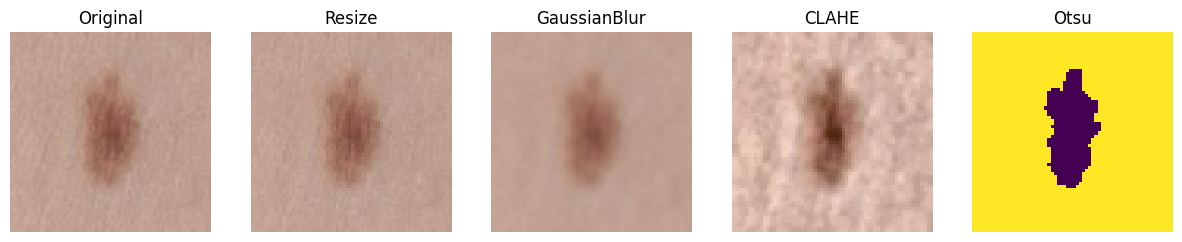

In [25]:
img_path = '../data/03_primary/ISIC_2024/images/ISIC_0087605.jpg'
original = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

step1_0 = Resize((64, 64)).fit_transform([original])
step2 = GaussianBlur((3, 3)).fit_transform(step1_0)
step3 = CLAHE_Color().fit_transform(step2)
step4 = OtsuThreshold().fit_transform(step3)

show_images([original, step1_0[0], step2[0], step3[0], step4[0]],
            titles=["Original", "Resize", "GaussianBlur", "CLAHE", "Otsu"])

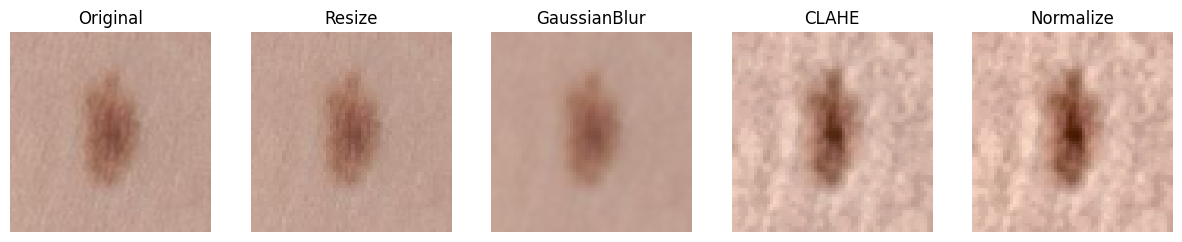

In [3]:
img_path = '../data/03_primary/ISIC_2024/images/ISIC_0087605.jpg'
original = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

step1 = Resize((64, 64)).fit_transform([original])
step2 = GaussianBlur((3, 3)).fit_transform(step1)
step3 = CLAHE_Color().fit_transform(step2)
step4 = Normalize().fit_transform(step3)

show_images([original, step1[0], step2[0], step3[0], step4[0]],
            titles=["Original", "Resize", "GaussianBlur", "CLAHE", "Normalize"])

# Carregando dataset completo

In [11]:
y_true = pd.read_csv('../data/03_primary/ISIC_2024/label.csv')
#y_true = y_true.iloc[:, 1].values
y_true[y_true.malignant == 1]

,isic_id,malignant
387,ISIC_0082829,1.0
935,ISIC_0096034,1.0
1245,ISIC_0104229,1.0
1846,ISIC_0119495,1.0
3478,ISIC_0157834,1.0
...,...,...
396165,ISIC_9877311,1.0
398671,ISIC_9941636,1.0
399936,ISIC_9972649,1.0
399943,ISIC_9972877,1.0


In [20]:
# ---------- Dataset ----------
base_path = r'..\data\03_primary\ISIC_2024'
image_folder = os.path.join(base_path, 'images')
csv_path = os.path.join(base_path, 'ISIC_2024_Permissive_Training_GroundTruth.csv')

# Lendo o CSV com os rótulos
df = pd.read_csv(csv_path)

# Separando as classes
df_class_1 = df[df['malignant'] == 1]
df_class_0 = df[df['malignant'] == 0]

# Amostragem da classe 0
df_class_0_sample = df_class_0.sample(n=len(df_class_1), random_state=42)

# Concatenando
df_sample = pd.concat([df_class_1, df_class_0_sample]).reset_index(drop=True)

# Função para carregar uma imagem
def load_image(filename, target_size=(128, 128)):
    img_path = os.path.join(image_folder, filename)
    img = cv2.imread(img_path+'.jpg')
    if img is None:
        print(f"Erro ao carregar a imagem: {img_path+'.jpg'}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img

# Carregando imagens e labels
images = []
labels = []

for _, row in df_sample.iterrows():
    img = load_image(row['isic_id'])
    if img is not None:
        images.append(img)
        labels.append(row['malignant'])

X = np.array(images)
y = np.array(labels)

In [5]:
# Converte os rótulos em one-hot encoding (se necessário)
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)

# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)


In [44]:
y_cat

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

# Comprovando se houve melhora ou piora com uso de determinada técnica

In [6]:
def create_cnn_model(input_shape, num_classes=2):
    """Cria um modelo CNN.
    Args:
        X_train (numpy.ndarray): Conjunto de dados de treinamento.
        num_classes (int): Número de classes.  
    Returns:
        model (keras.Sequential): Modelo CNN compilado.
    """

    data_augmentation = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.1),
        RandomZoom(0.1),
        RandomBrightness(0.1),
    ])

    model = Sequential([
        data_augmentation,
        Rescaling(1./255),
        Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'Precision', 'Recall'])

    return model

In [7]:
model = create_cnn_model(X_train.shape[1:], num_classes)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


Epoch 1/10


c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - Precision: 0.5413 - Recall: 0.6152 - accuracy: 0.5545 - loss: 1.0860 - val_Precision: 0.4362 - val_Recall: 0.4362 - val_accuracy: 0.4362 - val_loss: 0.6966
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - Precision: 0.5101 - Recall: 0.5598 - accuracy: 0.5183 - loss: 0.6933 - val_Precision: 0.4362 - val_Recall: 0.4362 - val_accuracy: 0.4362 - val_loss: 0.7110
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - Precision: 0.5173 - Recall: 0.5132 - accuracy: 0.5166 - loss: 0.7027 - val_Precision: 0.6351 - val_Recall: 0.5000 - val_accuracy: 0.6064 - val_loss: 0.6912
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - Precision: 0.6181 - Recall: 0.5298 - accuracy: 0.6032 - loss: 0.6911 - val_Precision: 0.4362 - val_Recall: 0.4362 - val_accuracy: 0.4362 - val_loss: 0.7359
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - Precision: 0.5089 - Recall: 0.4798 - accuracy: 0.5025 - loss: 0.6945 - val_Precision: 0.5682 - val_Recall: 0.5319 - v

c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
X_train.shape[1:]

(128, 128, 3)

In [ ]:

mask = (y.flatten() == 0) | (y.flatten() == 1)
X = X[mask]
y = y[mask]
y = y.flatten()

preprocess_pipeline = Pipeline([
    ('resize', Resize((64, 64))),
    ('blur', GaussianBlur()),
    ('clahe', CLAHE())
])

X_processed = preprocess_pipeline.fit_transform(X)
X_processed = np.array(X_processed) / 255.0  # normalizando
X_processed = np.expand_dims(X_processed, axis=-1)

# ---------- Train/Test split ----------
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = create_cnn_model(X_train.shape[1:], num_classes)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# ---------- Avaliação ----------
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5142 - loss: 0.7033 - val_accuracy: 0.4894 - val_loss: 0.6942
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5290 - loss: 0.6918 - val_accuracy: 0.4894 - val_loss: 0.6921
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4890 - loss: 0.6915 - val_accuracy: 0.5532 - val_loss: 0.6899
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6007 - loss: 0.6880 - val_accuracy: 0.5319 - val_loss: 0.6841
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5601 - loss: 0.6824 - val_accuracy: 0.4894 - val_loss: 0.7188
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        53
         1.0       0.55      1.00      0.71        65

    accuracy                           0.55       118
   macro avg       0.28      0.50      0.36       118
weighted avg       0.30      0.55      0.39       118



c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

In [32]:
pipelines = {
    'Pipeline 1: Resize -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
    ]),
    'Pipeline 2: Resize -> GaussianBlur -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
        ('blur', GaussianBlur())
    ]),
    'Pipeline 3: Resize -> GaussianBlur -> CLAHE (Color) -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
        ('blur', GaussianBlur()),
        ('clahe', CLAHE_Color())
    ]),
    'Pipeline 4: Resize -> CLAHE (Color) -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
        ('clahe', CLAHE_Color())
    ])
}

results = {}
epochs = 10 
batch_size = 32

for name, pipeline in pipelines.items():
    
    print(f"---> Testando {name} ")
    X_train_processed_base = pipeline.fit_transform(X_train, y_train)
    X_test_processed_base = pipeline.transform(X_test)
    print(X_train_processed_base.shape[1:])


---> Testando Pipeline 1: Resize -> Normalize 
(64, 64, 3)
---> Testando Pipeline 2: Resize -> GaussianBlur -> Normalize 
(64, 64, 3)
---> Testando Pipeline 3: Resize -> GaussianBlur -> CLAHE (Color) -> Normalize 
(64, 64, 3)
---> Testando Pipeline 4: Resize -> CLAHE (Color) -> Normalize 
(64, 64, 3)


---> Testando Pipeline 1: Resize -> Normalize 
Epoch 1/10


c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - Precision: 0.5000 - Recall: 0.4855 - accuracy: 0.5060 - loss: 0.7187 - val_Precision: 0.4836 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - Precision: 0.4969 - Recall: 0.5782 - accuracy: 0.5076 - loss: 0.6960 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - Precision: 0.5046 - Recall: 0.5122 - accuracy: 0.5322 - loss: 0.6915 - val_Precision: 0.5164 - val_Recall: 0.5339 - val_accuracy: 0.5169 - val_loss: 0.6909
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - Precision: 0.5475 - Recall: 0.5646 - accuracy: 0.5657 - loss: 0.6916 - val_Precision: 0.5789 - val_Recall: 0.5593 - val_accuracy: 0.5678 - val_loss: 0.6910
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - Precision: 0.4977 - Recall: 0.4185 - accuracy: 0.5074 - loss: 0.6937 - val_Precision: 0.5043 - val_Recall: 0.5000 - val_ac

c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - Precision: 0.4998 - Recall: 0.5618 - accuracy: 0.5205 - loss: 0.6998 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6908
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - Precision: 0.5231 - Recall: 0.4798 - accuracy: 0.5165 - loss: 0.6940 - val_Precision: 0.5871 - val_Recall: 0.7712 - val_accuracy: 0.6525 - val_loss: 0.6837
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - Precision: 0.5534 - Recall: 0.5694 - accuracy: 0.5582 - loss: 0.6891 - val_Precision: 0.6239 - val_Recall: 0.5763 - val_accuracy: 0.6017 - val_loss: 0.6912
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - Precision: 0.5473 - Recall: 0.5380 - accuracy: 0.5512 - loss: 0.6904 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6846
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - Precision: 0.4852 - Recall: 0.4856 - accuracy: 0.4851 - loss: 0.6853 - val_Precision: 0.6690 - val_Recall: 0.8220 - val_ac

c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - Precision: 0.5259 - Recall: 0.5689 - accuracy: 0.5291 - loss: 0.7427 - val_Precision: 0.6216 - val_Recall: 0.5847 - val_accuracy: 0.6271 - val_loss: 0.6856
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - Precision: 0.5709 - Recall: 0.5660 - accuracy: 0.5722 - loss: 0.6834 - val_Precision: 0.6370 - val_Recall: 0.7288 - val_accuracy: 0.6695 - val_loss: 0.6575
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - Precision: 0.6245 - Recall: 0.6510 - accuracy: 0.6506 - loss: 0.6435 - val_Precision: 0.7190 - val_Recall: 0.7373 - val_accuracy: 0.7288 - val_loss: 0.5963
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - Precision: 0.7038 - Recall: 0.7090 - accuracy: 0.7168 - loss: 0.6062 - val_Precision: 0.7069 - val_Recall: 0.6949 - val_accuracy: 0.6949 - val_loss: 0.5952
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - Precision: 0.6781 - Recall: 0.6664 - accuracy: 0.6847 - loss: 0.6018 - val_Precision: 0.6639 - val_Recall: 0.6695 - val_ac

c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - Precision: 0.5245 - Recall: 0.5527 - accuracy: 0.5622 - loss: 0.7116 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6980
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - Precision: 0.5466 - Recall: 0.4960 - accuracy: 0.5486 - loss: 0.6908 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6889
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - Precision: 0.5365 - Recall: 0.5343 - accuracy: 0.5375 - loss: 0.6840 - val_Precision: 0.7216 - val_Recall: 0.5932 - val_accuracy: 0.7119 - val_loss: 0.6770
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - Precision: 0.6124 - Recall: 0.6031 - accuracy: 0.6321 - loss: 0.6699 - val_Precision: 0.6931 - val_Recall: 0.5932 - val_accuracy: 0.6610 - val_loss: 0.6497
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - Precision: 0.5833 - Recall: 0.5911 - accuracy: 0.5883 - loss: 0.6761 - val_Precision: 0.6066 - val_Recall: 0.6271 - val_ac

KeyError: 'val_recall'

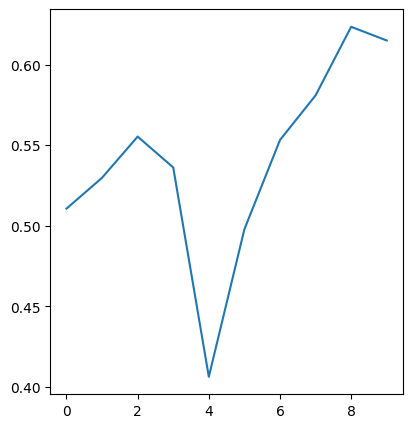

In [48]:
pipelines = {
    'Pipeline 1: Resize -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
    ]),
    'Pipeline 2: Resize -> GaussianBlur -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
        ('blur', GaussianBlur())
    ]),
    'Pipeline 3: Resize -> GaussianBlur -> CLAHE (Color) -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
        ('blur', GaussianBlur()),
        ('clahe', CLAHE_Color())
    ]),
    'Pipeline 4: Resize -> CLAHE (Color) -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
        ('clahe', CLAHE_Color())
    ])
}

results = {}
epochs = 10 
batch_size = 32

for name, pipeline in pipelines.items():
    
    print(f"---> Testando {name} ")
    X_train_processed_base = pipeline.fit_transform(X_train, y_train)
    X_test_processed_base = pipeline.transform(X_test)

    input_shape = X_train_processed_base.shape[1:]
    model = create_cnn_model(input_shape)

    history = model.fit(
        X_train_processed_base, y_train,
        validation_data=(X_test_processed_base, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    y_pred_test_prob = model.predict(X_test_processed_base)
    y_pred_test = (y_pred_test_prob > 0.5).astype(int)[:, 1]

    accuracy_aug = accuracy_score(y_test[:, 1], y_pred_test)
    precision_aug = precision_score(y_test[:, 1], y_pred_test)
    recall_aug = recall_score(y_test[:, 1], y_pred_test)
    f1_aug = f1_score(y_test[:, 1], y_pred_test)
    auc_aug = roc_auc_score(y_test[:, 1], y_pred_test_prob[:, 1])

    results[name] = {
        'accuracy': accuracy_aug,
        'precision': precision_aug,
        'recall': recall_aug,
        'f1': f1_aug,
        'auc': auc_aug,
        'history': history.history
    }

print("\n--- Resultados da Validação ---")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Acurácia: {metrics['accuracy']:.4f}")
    print(f"  Precisão: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1']:.4f}")
    print(f"  AUC: {metrics['auc']:.4f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['history']['Recall'], label='Train Recall')
    plt.plot(metrics['history']['val_recall'], label='Validation Recall')
    plt.title(f'{name} - Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['history']['loss'], label='Train Loss')
    plt.plot(metrics['history']['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

best_pipeline_name = max(results, key=lambda k: results[k]['Recall']) 
best_pipeline = pipelines[best_pipeline_name]

print(f"\n--- O melhor pipeline é o: ({best_pipeline_name}) ---")


In [47]:
results

{'Pipeline 1: Resize -> Normalize': {'accuracy': 0.6186440677966102,
  'precision': 0.57,
  'recall': 0.9661016949152542,
  'f1': 0.7169811320754716,
  'auc': np.float64(0.8580867566791152),
  'history': {'Precision': [0.5183150172233582,
    0.47575056552886963,
    0.5520833134651184,
    0.5021276473999023,
    0.5247148275375366,
    0.5841785073280334,
    0.5568627715110779,
    0.6057142615318298,
    0.6564551591873169,
    0.6646464467048645],
   'Recall': [0.6021276712417603,
    0.4382978677749634,
    0.4510638415813446,
    0.5021276473999023,
    0.5872340202331543,
    0.6127659678459167,
    0.6042553186416626,
    0.6765957474708557,
    0.6382978558540344,
    0.699999988079071],
   'accuracy': [0.5148935914039612,
    0.4723404347896576,
    0.5361701846122742,
    0.5,
    0.5297872424125671,
    0.6000000238418579,
    0.5659574270248413,
    0.6212766170501709,
    0.6553191542625427,
    0.6893616914749146],
   'loss': [0.7310135960578918,
    0.6938592195510864,

# Criando mapa de calor com o saliency_map

In [28]:
import tensorflow as tf

In [49]:
def saliency_map(model, image):
    image = tf.convert_to_tensor(image[None, ...])  # adiciona batch dimension
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        loss = predictions[0][0]  # valor da saída (classe)

    grads = tape.gradient(loss, image)[0]  # gradiente em relação à imagem
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)  # maior influência entre canais (1 canal no caso)
    
    # Normaliza o mapa
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-10)

    return saliency.numpy()

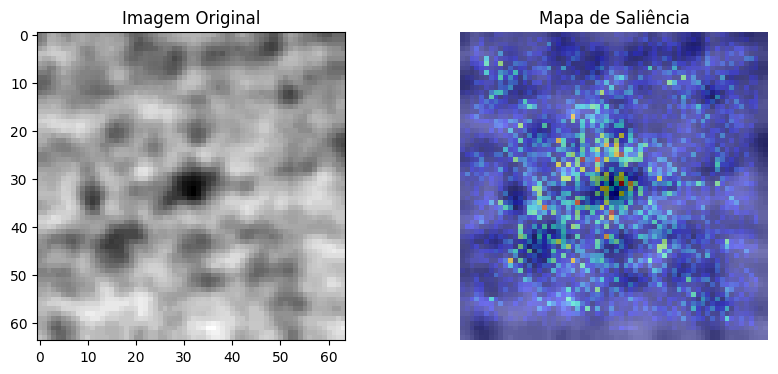

In [50]:
# Escolha uma imagem de teste
img = X_test[0]  # imagem com shape (64, 64, 1)

# Chamada
saliency = saliency_map(model, img)

# Visualização
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title("Imagem Original")

plt.subplot(1,2,2)
plt.imshow(img.squeeze(), cmap='gray')
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.title("Mapa de Saliência")
plt.axis('off')
plt.show()